In [1]:
import numpy as np
import pandas as pd
import math
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsRegressor

import matplotlib.pyplot as plt

In [2]:
#edit directory to userID
userID = 'opeters1'

team_df = pd.read_csv('/home/'+ userID +'/scratch/archive/Teams.csv')
player_df = pd.read_csv('/home/'+ userID +'/scratch/archive/Batting.csv')
#pitching_df = pd.read_csv('/home/'+ userID +'/scratch/archive/pitching.csv')
uncleanedSal_df = pd.read_csv('/home/'+ userID +'/scratch/archive/Salaries.csv')

### Cleaning dataset - 
arrived at year 1947 because it was the most recent notable change in the league (Desegregation)
kept G, W, R, AB, H, 2B, 3B, HR, BB, SO, CS, SB, HBP, SF, and FP because they pertain to the statistics we intend on using for our models.

While it matters for a team's winning percentage, runs are less relevant for a specific player (there are a lot of factors that could bring someone home, it's not up to them), and it might overwhelm the model.

NOTE: We would have included SF and HBP, however, the data was not recorded for games before the year 2000 and it would cut off too much of our data if we ignored the 1947-1999 seasons.

In [3]:
cleaned_years = team_df[team_df.yearID >= 1947]
cleaned_team = cleaned_years[['G', 'W', 'AB', 'H', '2B', '3B', 'HR', 'BB', 'SO', 'CS', 'SB', 'FP']]
cleaned_team = cleaned_team.dropna()

# calculate winning percentage, then drop the W and G columns
cleaned_team["win_perc"] = cleaned_team["W"] / cleaned_team["G"]
cleaned_team = cleaned_team.drop(['W', 'G'], axis = 1)

### Normalizing Data set

Because all of these stats are based off of at bats (AB), we opt to normalize the dataset based off of this.

In [4]:
def normalize_df(df):
    normalized = df.copy(deep=True)
    included_stats = ['H', '2B', '3B', 'HR', 'BB', 'SO', 'CS', 'SB'] #REMOVED FP, removed R, dropping AB after normalizing
    normalized['H'] = normalized['H'] - normalized['2B'] - normalized['3B'] - normalized['HR']
    for stat in included_stats:
        normalized[stat] = normalized[stat] / normalized["AB"]
    normalized = normalized.drop(['AB'], axis = 1)
    
    # normalize each column based on min/max to be on a range of 0 and 1
    result = normalized.copy()
    for feature_name in included_stats:
        max_value = normalized[feature_name].max()
        min_value = normalized[feature_name].min()
        result[feature_name] = (normalized[feature_name] - min_value) / (max_value - min_value)
    return result


In [5]:
# standardize data sets
normalized_team = normalize_df(cleaned_team)
included_stats = ['H', '2B', '3B', 'HR', 'BB', 'SO', 'CS', 'SB']
y = normalized_team[['win_perc']]
X = normalized_team[included_stats]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [6]:
#set up linear regression

reg = LinearRegression().fit(x_train, y_train)
lr_acc = reg.score(x_test, y_test)
print('"Accuracy" is', lr_acc, '\n\n')

# we can use ALL of the data to create a regression, because we'll be "testing" not on these teams, but on players instead
true_reg = LinearRegression().fit(X, y)

print("Weights:")
print(tuple(zip(true_reg.coef_[0], included_stats)))
print("Intercept:" + str(true_reg.intercept_))


"Accuracy" is 0.2858738303017132 


Weights:
((0.1437930963450888, 'H'), (0.00981612120859117, '2B'), (0.04565299228158608, '3B'), (0.19303170024445593, 'HR'), (0.09924158594991374, 'BB'), (-0.03904679363780258, 'SO'), (-0.07461915212315173, 'CS'), (0.15227352843513156, 'SB'))
Intercept:[0.27628407]


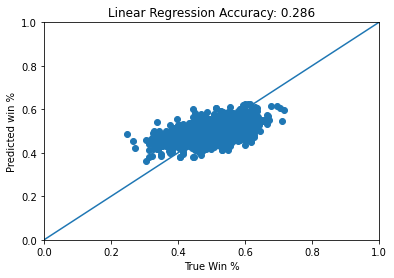

In [7]:
# Plotting true win % vs Pred win % on teams
fig, ax = plt.subplots()

pred_X = []
for i, stats in X.iterrows():
    pred_X.append(true_reg.predict([stats]))

ax.plot([0,1],[0,1], transform=ax.transAxes)
    
plt.scatter(y, pred_X)
plt.title('Linear Regression Accuracy: %.3f' % lr_acc)
plt.xlabel('True Win %')
plt.ylabel('Predicted win %')
plt.xlim([0, 1])
plt.ylim([0, 1])

plt.show()

## Describing our linear regression

The linear regression model set up above looks at hits, doubles, triples, home runs, walks, strike outs, times caught stealing, and succesful steals. *Hits have been modified to just represent singles*

It doesn't look at runs, at bats, and fielding percentage. This is because runs, while good at predicting a team's win percentage, says less about an individual player. At bats are "normalized" out of the equation, and fielding percentage, while relevant, seems difficult to integrate into the data without pulling from a different spreadsheet (and even then looks difficult).

When applying this model to specific players it's important to note that the output "winning percentage" that it estimates won't easily correspond to a teams winning percentage. That's because the model was trained on a *team's* worth of hits/runs/etc. This doesn't translate to a single player because a single player has roughly a ninth worth of these stats. However, the output that we come up with will still be able to be used to compare different players, and rank them.



## A brief Exploration of Random Forest Regression

In [8]:
# Set up random forest regressor

forest_regr = RandomForestRegressor(max_depth=100, random_state=1)
forest_regr.fit(x_train, y_train)
forest_acc = forest_regr.score(x_test, y_test)

print('"Accuracy" is', forest_acc, '\n\n')

true_forest_regr = RandomForestRegressor(max_depth=100, random_state=0)
true_forest_regr.fit(X, y)


<ipython-input-8-0611df2141aa>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest_regr.fit(x_train, y_train)


"Accuracy" is 0.23516832675563404 




<ipython-input-8-0611df2141aa>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  true_forest_regr.fit(X, y)


RandomForestRegressor(max_depth=100, random_state=0)

2490


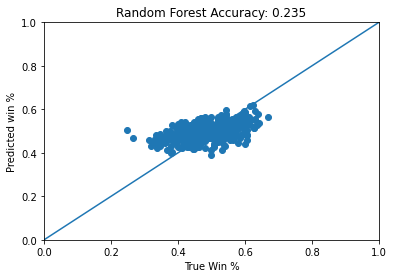

In [9]:
# Plotting true win % vs Pred win % on teams

fig, ax = plt.subplots()

forest_pred_X = []
for i, stats in x_test.iterrows():
    forest_pred_X.append(forest_regr.predict([stats]))

print(i)
ax.plot([0,1],[0,1], transform=ax.transAxes)

plt.scatter(y_test, forest_pred_X)
plt.title('Random Forest Accuracy: %.3f' % forest_acc)
plt.xlabel('True Win %')
plt.ylabel('Predicted win %')
plt.xlim([0, 1])
plt.ylim([0, 1])

plt.show()


In [10]:
# only get players after integration era who have more than 150 at bats. NOTE:can also modify to 100, or 50 if we want.
cleaned_player_years = player_df[player_df.yearID >= 1947][player_df.AB >= 150].dropna()
normalized_players = normalize_df(cleaned_player_years)
player_np = normalized_players[['H', '2B', '3B', 'HR', 'BB', 'SO', 'CS', 'SB']].to_numpy()

lin_reg_player_rank = []
rf_player_rank = []

for i, player_info in enumerate(player_np):
    
    p_id = str(cleaned_player_years.iloc[[i]]['playerID'].item())
    yr_id = str(cleaned_player_years.iloc[[i]]['yearID'].item())
    lin_reg_score = true_reg.predict([player_info])[0][0]
    rf_score = true_forest_regr.predict([player_info])[0]
    
    
    lin_reg_player_rank.append((lin_reg_score, p_id, yr_id))
    rf_player_rank.append((rf_score, p_id, yr_id))

<ipython-input-10-7e3183960f35>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cleaned_player_years = player_df[player_df.yearID >= 1947][player_df.AB >= 150].dropna()


In [11]:
lin_reg_player_rank.sort(key = lambda x: x[0])
rf_player_rank.sort(key = lambda x: x[0])
print("Top 50 Players based on Linear Reg: \t\tTop 50 Players based on Random Forest Reg:")
for i in range(-1,-50,-1):
    print(str(lin_reg_player_rank[i]) + '\t' + str(rf_player_rank[i]))
    
print("-------")


Top 50 Players based on Linear Reg: 		Top 50 Players based on Random Forest Reg:
(0.5938389146641071, 'bondsba01', '2004')	(0.5763548939610338, 'bondsba01', '2002')
(0.571198901268854, 'bondsba01', '2002')	(0.57586054043634, 'bondsba01', '2004')
(0.5553009746589084, 'bondsba01', '2001')	(0.5548006173923611, 'bondsba01', '2001')
(0.5458723409900569, 'bondsba01', '2003')	(0.5439933978475165, 'willite01', '1955')
(0.5373352561814201, 'raineti01', '1981')	(0.5385964474002166, 'thomafr04', '1994')
(0.5313546064851897, 'daviser01', '1986')	(0.5382046059300216, 'mantlmi01', '1962')
(0.5284278473541106, 'morgajo02', '1976')	(0.537412716501837, 'mcgwima01', '1995')
(0.5276598232251708, 'morgajo02', '1975')	(0.5370573410940532, 'bondsba01', '2003')
(0.525560942553611, 'willite01', '1957')	(0.5369639251549232, 'mantlmi01', '1956')
(0.5244995410825972, 'henderi01', '1989')	(0.5358444676143029, 'mcgwima01', '1996')
(0.523324578398204, 'mantlmi01', '1957')	(0.5330540470920091, 'willite01', '1957')
(

In [12]:
# Write the ranking as csv

lr_df = pd.DataFrame(lin_reg_player_rank)
lr_df.to_csv("lr_player_rank.csv", index=False,  header=["Score", "playerID", "Year"])

rf_df = pd.DataFrame(rf_player_rank)
rf_df.to_csv("rf_player_rank.csv", index=False,  header=["Score", "playerID", "Year"])

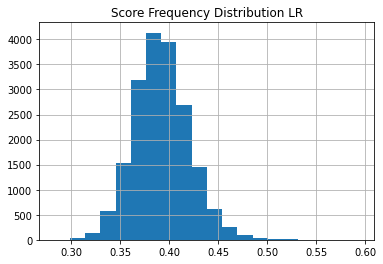

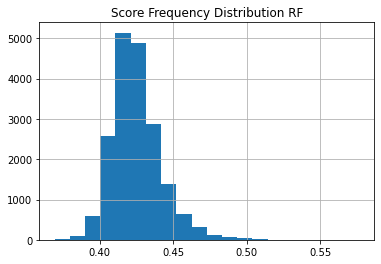

In [13]:
#Histogram to visualize distribution spread
lr_df.rename(columns={0 : 'Score Frequency Distribution LR'}, inplace=True)
rf_df.rename(columns={0 : 'Score Frequency Distribution RF'}, inplace=True)
hist = lr_df.hist(bins=20)
hist2 = rf_df.hist(bins=20)

## Salary vs Team Worth Evaluation

In [14]:
# only get players after integration era who have more than 150 at bats. NOTE:can also modify to 100, or 50 if we want.
cleaned_player_years = player_df[player_df.yearID >= 1947][player_df.AB >= 150].dropna()
normalized_players = normalize_df(cleaned_player_years)
player_np = normalized_players[['H', '2B', '3B', 'HR', 'BB', 'SO', 'CS', 'SB']].to_numpy()

player_rank = []
player_rank_salary = []
for i, player_info in enumerate(player_np):
    
    p_id = str(cleaned_player_years.iloc[[i]]['playerID'].item())
    yr_id = str(cleaned_player_years.iloc[[i]]['yearID'].item())
    score = true_reg.predict([player_info])[0][0]
    player_rank.append((score, p_id, yr_id))
    player_rank_salary.append((score, p_id, yr_id))

<ipython-input-14-3b2e36356bdf>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cleaned_player_years = player_df[player_df.yearID >= 1947][player_df.AB >= 150].dropna()


In [15]:
uncleanedSal_df

,yearID,teamID,lgID,playerID,salary
0,1985,ATL,NL,barkele01,870000
1,1985,ATL,NL,bedrost01,550000
2,1985,ATL,NL,benedbr01,545000
3,1985,ATL,NL,campri01,633333
4,1985,ATL,NL,ceronri01,625000
...,...,...,...,...,...
25570,2015,WAS,NL,treinbl01,512800
25571,2015,WAS,NL,ugglada01,507500
25572,2015,WAS,NL,werthja01,21000000
25573,2015,WAS,NL,zimmejo02,16500000


In [85]:
pd.options.mode.chained_assignment = None  # default='warn'
df = pd.DataFrame(data=player_rank_salary)
df.columns = ['score', 'playerID', 'yearID']
df['sal'] = 0
salaries_df = uncleanedSal_df[['yearID', 'playerID', 'salary']]

for i in range(len(df)):
    if df['playerID'][i] in salaries_df.values and int(df['yearID'][i]) in salaries_df.values:
            index_list = salaries_df[(salaries_df['playerID'] == df['playerID'][i]) & (salaries_df['yearID'] == int(df['yearID'][i]))].index
            if len(index_list) == 1:
                df['sal'][i] = salaries_df.iloc[index_list]['salary'].astype(int)

df = df[df.sal != 0]
df

,score,playerID,yearID,sal
7659,0.419911,aguaylu01,1985,237000
7660,0.371442,almonbi01,1985,255000
7662,0.401720,armasto01,1985,915000
7663,0.415972,ashbyal01,1985,416667
7664,0.392923,backmwa01,1985,200000
...,...,...,...,...
18736,0.373947,youngde03,2015,2250000
18737,0.376446,zimmery01,2015,14000000
18738,0.383162,zobribe01,2015,7500000
18739,0.393640,zobribe01,2015,7500000


In [86]:
salary_data = df

Set up the KNN Regressor:

In [87]:
# we can use such a high K value because our overall dataset size is so big (10212)
neigh = KNeighborsRegressor(n_neighbors=10)
X = salary_data[['score']]
y = salary_data[['sal']]


start = 1985
salary_data['yearID'] = pd.to_numeric(salary_data['yearID'])
average = []
for i in range(2015-1985):
    data = salary_data[salary_data.yearID == start+i]
    X = data[['score']]
    y = data[['sal']]
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
    neigh.fit(x_train, y_train)
    average.append(neigh.score(x_test, y_test))


print(sum(average)/len(average))

0.04688961441491181


In [68]:
salary_data['true_worth'] = 0
data_knn = salary_data[salary_data.yearID == 2015]
X = data_knn[['score']]
y = data_knn[['sal']]
for i in range(len(data_knn)):
    playerScore = []
    playerScore.append(data_knn['score'][9883+i])
    score = pd.DataFrame(data=playerScore)
    playerSal = neigh.predict(score)
    data_knn['true_worth'][i+9883] = playerSal
print(data_knn)

       level_0  index     score   playerID  yearID       sal  true_worth
9883      9883  18361  0.403840  abreujo02    2015   8666000     7656650
9884      9884  18362  0.357545  ackledu01    2015   2600000     2655740
9885      9885  18363  0.363763  adamsma01    2015    534000     3530660
9886      9886  18364  0.358230  ahmedni01    2015    508500     1856740
9887      9887  18366  0.385322  alonsyo01    2015   1650000     3611680
...        ...    ...       ...        ...     ...       ...         ...
10207    10207  18736  0.373947  youngde03    2015   2250000     3956110
10208    10208  18737  0.376446  zimmery01    2015  14000000     4782056
10209    10209  18738  0.383162  zobribe01    2015   7500000     8340000
10210    10210  18739  0.393640  zobribe01    2015   7500000     7217500
10211    10211  18740  0.320524  zuninmi01    2015    523500     1442090

[329 rows x 7 columns]


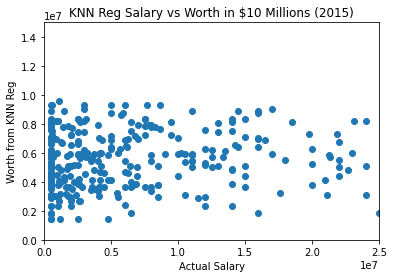

In [83]:
import matplotlib.pyplot as plot
sal_lst = data_knn['sal'].to_list()
val_lst = data_knn['true_worth'].to_list()
for i in range(len(sal_lst)):
    if sal_lst[i] == 0:
        print(sal_lst[i])
plot.scatter(sal_lst, val_lst)
plot.title('KNN Reg Salary vs Worth in $10 Millions (2015)')
plot.xlabel('Actual Salary')
plot.ylabel('Worth from KNN Reg')
plot.xlim([0, 25000000])
plot.ylim([0, 15000000])
plot.show()

0.0965930556093878


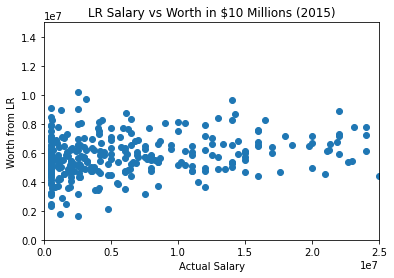

In [80]:
data_reg = salary_data[salary_data.yearID == 2015]
data_reg['true_worth'] = 0
score = pd.DataFrame(data=data_reg['score'])
sal = pd.DataFrame(data=data_reg['sal']) 
x_train, x_test, y_train, y_test = train_test_split(score, sal, test_size=0.25, random_state=0)
test_reg = LinearRegression().fit(x_train, y_train)
print(test_reg.score(x_test, y_test))
reg = LinearRegression().fit(score, sal)
for i in range(len(data_reg)):
    player_score = []                       
    player_score.append(data_knn['score'][9883+i])
    score = pd.DataFrame(data=player_score)
    des_sal = reg.predict(score)
    data_reg['true_worth'][i+9883] = des_sal
    
sal_lst = data_reg['sal'].to_list()
val_lst = data_reg['true_worth'].to_list()  
plot.scatter(sal_lst, val_lst)
plot.title('LR Salary vs Worth in $10 Millions (2015)')
plot.xlabel('Actual Salary')
plot.ylabel('Worth from LR')
plot.xlim([0, 25000000])
plot.ylim([0, 15000000])
plot.show()